In [89]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py, os
from mpl_toolkits import mplot3d
from imp import reload

from scipy.signal import resample

from cca import ComplexityComponentsAnalysis
from cca.cov_util import calc_cross_cov_mats_from_data
import cca.synth_data
from cca.data_util import form_lag_matrix
from cca.cca import pi_fft_loss_fn
from cca import style

from info_measures.continuous import kraskov_stoegbauer_grassberger as ksg

In [2]:
def gen_noise_cov(N, D, var, V_noise=None):
    noise_spectrum = var*np.exp(-2*np.arange(N)/D)
    if V_noise is None:
        V_noise = scipy.stats.ortho_group.rvs(N)
    noise_cov = np.dot(V_noise, np.dot(np.diag(noise_spectrum), V_noise.T))
    return noise_cov

def random_basis(N, D):
    return scipy.stats.ortho_group.rvs(N)[:, :D]

def median_subspace(N, D, num_samples=5000, V_0=None):
    subspaces = np.zeros((num_samples, N, D))
    angles = np.zeros((num_samples, min(D, V_0.shape[1])))
    if V_0 is None:
        V_0 = np.eye(N)[:, :D]
    for i in range(num_samples):
        subspaces[i] = random_basis(N, D)
        angles[i] = np.rad2deg(scipy.linalg.subspace_angles(V_0, subspaces[i]))
    median_angles = np.median(angles, axis=0)
    median_subspace_idx = np.argmin( np.sum((angles-median_angles)**2, axis=1) )
    median_subspace = subspaces[median_subspace_idx]
    return median_subspace

In [112]:
def gen_heatmap(cross_cov_mats, N_theta=100):
    N_phi = N_theta
    theta = np.linspace(0, np.pi, N_theta)
    phi = np.linspace(0, np.pi, N_phi)
    
    heatmap = np.zeros((N_theta, N_phi))
    
    def pi_val(theta, phi):
        x = np.cos(phi)*np.sin(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(theta)
        v = np.array([x, y, z]).reshape((3, 1))
        pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats, proj=v)
        return pi
    
    for theta_idx in range(N_theta):
        for phi_idx in range(N_phi):
            pi = pi_val(theta[theta_idx], phi[phi_idx])
            heatmap[theta_idx, phi_idx] = pi
            
    return heatmap

def gen_heatmap_knn(X, T_pi, N_theta=100):
    N_phi = N_theta
    theta = np.linspace(0, np.pi, N_theta)
    phi = np.linspace(0, np.pi, N_phi)
    
    heatmap = np.zeros((N_theta, N_phi))
    
    def pi_val(theta, phi):
        x = np.cos(phi)*np.sin(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(theta)
        v = np.array([x, y, z]).reshape((3, 1))
        X_lag = form_lag_matrix(X.dot(v), 2 * T_pi)
        mi = ksg.MutualInformation(X_lag[:, :T_pi], X_lag[:, T_pi:], add_noise=True)
        pi = mi.mutual_information(n_jobs=4)
        return pi
    
    for theta_idx in range(N_theta):
        for phi_idx in range(N_phi):
            pi = pi_val(theta[theta_idx], phi[phi_idx])
            heatmap[theta_idx, phi_idx] = pi
            
    return heatmap

def gen_heatmap_fft(X, T_pi, N_theta=100):
    N_phi = N_theta
    theta = np.linspace(0, np.pi, N_theta)
    phi = np.linspace(0, np.pi, N_phi)
    
    heatmap = np.zeros((N_theta, N_phi))
    
    def pi_val(theta, phi):
        x = np.cos(phi)*np.sin(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(theta)
        v = np.array([x, y, z]).reshape((3, 1))
        Xp = X.dot(v)
        pi = pi_fft_loss_fn(Xp, T_pi)
        return pi.detach().cpu().numpy()
    
    for theta_idx in range(N_theta):
        for phi_idx in range(N_phi):
            pi = pi_val(theta[theta_idx], phi[phi_idx])
            heatmap[theta_idx, phi_idx] = pi
            
    return heatmap

def disp_heatmap(ax, heatmap, show_xlabels=True, show_ylabels=True, title=None):
    N_theta, N_phi = heatmap.shape
    im = ax.imshow(heatmap, origin="lower left", cmap="gray", aspect='equal')
    if show_xlabels:
        ax.set_xlabel("$\phi$", fontsize=style.axis_label_fontsize, labelpad=-3)
        ax.set_xticks([0, N_phi-1])
        ax.set_xticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_xticks([])
    if show_ylabels:
        ax.set_ylabel("$\\theta$", fontsize=style.axis_label_fontsize, labelpad=-10)
        ax.set_yticks([0, N_theta-1])
        ax.set_yticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_yticks([])
    
    ax.set_xlim([0, heatmap.shape[1]-1])
    ax.set_ylim([0, heatmap.shape[0]-1])
        
    #cbar = fig.colorbar(im, ax=ax)
    if title is not None:
        ax.set_title(title, fontsize=style.title_fontsize, pad=1)
    #cbar.set_label('PI [bits]', rotation=90, fontsize=14, labelpad=10)
    
    return vals_at_peaks


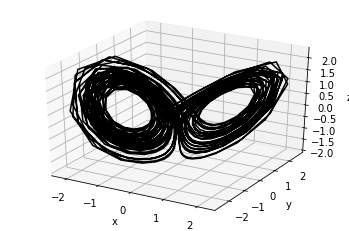

In [11]:
T_pi = 1
T = 10000
integration_dt = 0.005
data_dt = 0.005
X = cca.synth_data.gen_lorenz_system(T, integration_dt, data_dt)
X = resample(X, X.shape[0] // 10, axis=0)
X = X[1000:]
X -= X.mean(axis=0)
X /= X.std(axis=0)
X += np.random.randn(*X.shape) * np.sqrt(1e-5)
cross_cov_mats = calc_cross_cov_mats_from_data(X, 2 * T_pi)
#cross_cov_mats[0] += np.eye(3) * 2e-5

ax = plt.axes(projection='3d')
ax.plot3D(X[:1000,0], X[:1000,1], X[:1000,2], 'black')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [4]:
#Set parameters
T_pi = 1
hd = 30
noise_dim = 7
snr = 1.

#Generate Lorenz dynamics
num_samples = 10000
integration_dt = 0.005
data_dt = 0.005
X_dynamics = cca.synth_data.gen_lorenz_system((num_samples + 1000)*data_dt, integration_dt, data_dt)[1000:]
X_dynamics = resample(X_dynamics, num_samples, axis=0)
X_dynamics = (X_dynamics - X_dynamics.mean(axis=0))/X_dynamics.std(axis=0)
dynamics_var = np.max(scipy.linalg.eigvalsh(np.cov(X_dynamics.T)))

#Generate dynamics embedding matrix (will remain fixed)
np.random.seed(42)
V_dynamics = random_basis(hd, 3)
X = np.dot(X_dynamics, V_dynamics.T)

#Generate a subspace with median principal angles w.r.t. dynamics subspace
V_noise = median_subspace(hd, noise_dim, num_samples=50000, V_0=V_dynamics)

#Extend V_noise to a basis for R^N
V_noise_comp = scipy.linalg.orth(np.eye(hd) - np.dot(V_noise, V_noise.T))
V_noise = np.concatenate((V_noise, V_noise_comp), axis=1)

noise_var = dynamics_var/snr

#Generate noise covariacne
noise_cov = gen_noise_cov(hd, noise_dim, noise_var, V_noise=V_noise)

#Generate noisy data
X_noisy = X + np.random.multivariate_normal(mean=np.zeros(hd), cov=noise_cov, size=num_samples)
X_noisy = X_noisy - X_noisy.mean(axis=0)

#Compute PSD+Toeplitz spatiotemporal covariance
cross_cov_mats_hd = calc_cross_cov_mats_from_data(X_noisy, 2 * T_pi)
X_lag_hd = form_lag_matrix(X_noisy, 2 * T_pi)

# knn

In [13]:
N_theta = 100

la_heatmap_cca = gen_heatmap(cross_cov_mats, N_theta=N_theta)
la_heatmap_knn = gen_heatmap_knn(X, T_pi, N_theta=N_theta)

In [21]:
d = np.load('knn-gp.npz')
la_heatmap_knn = d['la_heatmap_knn']
la_heatmap_cca = d['la_heatmap_cca']
la_knn_pi = d['la_knn_pi']
la_gp_pi = d['la_gp_pi']

In [14]:
n_samples = 10000
la_knn_pi = np.zeros(n_samples)
la_gp_pi = np.zeros(n_samples)


for ii in range(n_samples):
    v = scipy.stats.special_ortho_group.rvs(3)[0].reshape((3, 1))
    pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats, proj=v)
    la_gp_pi[ii] = pi

    X_lag_v = np.dot(X_lag, v)
    mi = ksg.MutualInformation(X_lag_v, X_lag_v, add_noise=True)
    pi = mi.mutual_information(n_jobs=4)
    la_knn_pi[ii] = pi

la_gp_pi -= la_gp_pi.min()
la_gp_pi /= la_gp_pi.max()
la_knn_pi -= la_knn_pi.min()
la_knn_pi /= la_knn_pi.max()
np.savez('knn-gp.npz', la_heatmap_knn=la_heatmap_knn, la_heatmap_cca=la_heatmap_cca,
         la_knn_pi=la_knn_pi, la_gp_pi=la_gp_pi)

In [82]:
n_samples = 10000
la_knn_pi_hd = np.zeros(n_samples)
la_gp_pi_hd = np.zeros(n_samples)

for ii in range(n_samples):
    v = scipy.stats.special_ortho_group.rvs(hd)[0].reshape(hd, 1)
    pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats_hd, proj=v)
    la_gp_pi_hd[ii] = pi

    X_lag = form_lag_matrix(X_noisy.dot(v), 2 * T_pi)
    mi = ksg.MutualInformation(X_lag[:, T_pi:], X_lag[:, :T_pi], add_noise=True)
    pi = mi.mutual_information(n_jobs=4)
    la_knn_pi_hd[ii] = pi

la_gp_pi_hd -= la_gp_pi_hd.min()
la_gp_pi_hd /= la_gp_pi_hd.max()
la_knn_pi_hd -= la_knn_pi_hd.min()
la_knn_pi_hd /= la_knn_pi_hd.max()
np.savez('knn-gp-hd.npz', la_knn_pi_hd=la_knn_pi_hd, la_gp_pi_hd=la_gp_pi_hd)

0.27499999999999997 0.7 0.2625


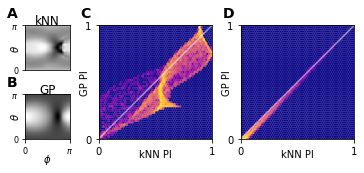

In [116]:
figsize=(5, 2.25)
fig = plt.figure(figsize=figsize)

be = .15
te = .15
le = .05
hg = .08
vg = .15
short = (1. - be - te - vg) / 2.
tall = (1. - be - te)
widtht = tall * figsize[1] / figsize[0]
widths = short * figsize[1] / figsize[0]

print(short, tall, width)

ax0 = fig.add_axes([le, be, widths, short])
ax1 = fig.add_axes([le, be + short + vg, widths, short])
ax2 = fig.add_axes([le + widths + hg, be, widtht, tall])
ax3 = fig.add_axes([le + widths + widtht + 2*hg, be, widtht, tall])

disp_heatmap(ax0, la_heatmap_cca,
             title='GP',
             show_xlabels=True,
             show_ylabels=True)
disp_heatmap(ax1, la_heatmap_knn,
             title='kNN',
             show_xlabels=False,
             show_ylabels=True)

ax2.hexbin(la_knn_pi, la_gp_pi, gridsize=50, cmap='plasma', bins='log', lw=.15)
ax3.hexbin(la_knn_pi_hd, la_gp_pi_hd, gridsize=50, cmap='plasma', bins='log', lw=.15)
for ax in [ax2, ax3]:
    ax.plot([0, 1], [0, 1], 'w', alpha=.5)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel('kNN PI', labelpad=-7)
    ax.set_ylabel('GP PI', labelpad=-5)

x = le
y = be + tall
dx = -.05
dy = -.05
fig.text(x+dx, y-dy, 'A', **style.panel_letter_fontstyle)
fig.text(x+dx, be + short-dy, 'B', **style.panel_letter_fontstyle)
fig.text(le + widths + hg+dx, y-dy, 'C', **style.panel_letter_fontstyle)
fig.text(le + widths + widtht + 2*hg+dx, y-dy, 'D', **style.panel_letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/gp_knn.pdf'), dpi=300)
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/gp_knn.png'), dpi=300)

# fft

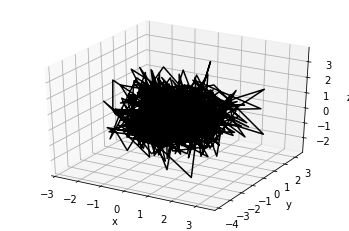

In [7]:
T_pi = 20
T_fft = 1000
T = 200000
cov = cca.synth_data.gen_gp_kernel('squared_exp', .1, 1.)
X1 = cca.synth_data.sample_gp(T_fft, 1, cov, num_to_concat=T // T_fft)
cov = cca.synth_data.gen_gp_kernel('squared_exp', .1, 2.5)
X2 = cca.synth_data.sample_gp(T_fft, 1, cov, num_to_concat=T // T_fft)
cov = cca.synth_data.gen_gp_kernel('squared_exp', .1, .25)
X3 = cca.synth_data.sample_gp(T_fft, 1, cov, num_to_concat=T // T_fft)
X = np.concatenate([X1, X2, X3], axis=1)
X -= X.mean(axis=0)
X /= X.std(axis=0)
cross_cov_mats = calc_cross_cov_mats_from_data(X, 2 * T_pi)

ax = plt.axes(projection='3d')
ax.plot3D(X[:1000,0], X[:1000,1], X[:1000,2], 'black')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [8]:
N_theta = 100

gp_heatmap_cca = gen_heatmap(cross_cov_mats, N_theta=N_theta)
gp_heatmap_fft = gen_heatmap_fft(X, T_fft, N_theta=N_theta)

In [9]:
n_samples = 50000
gp_fft_pi = np.zeros(n_samples)
gp_gp_pi = np.zeros(n_samples)

for ii in range(n_samples):
    v = scipy.stats.special_ortho_group.rvs(3)[0].reshape((3, 1))
    pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats, proj=v)
    gp_gp_pi[ii] = pi

    Xp = X.dot(v)
    pi = pi_fft_loss_fn(Xp, T_fft).detach().cpu().numpy()
    gp_fft_pi[ii] = pi

gp_gp_pi -= gp_gp_pi.min()
gp_gp_pi /= gp_gp_pi.max()
gp_fft_pi -= gp_fft_pi.min()
gp_fft_pi /= gp_fft_pi.max()

0.3 0.75 0.42857142857142855


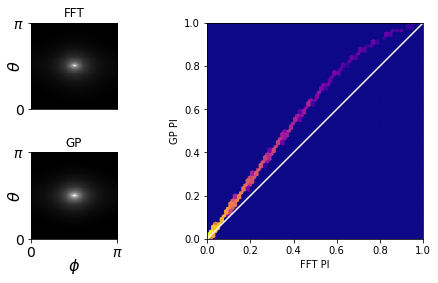

In [10]:
figsize=(7, 4)
fig = plt.figure(figsize=figsize)

be = .15
te = .1
le = .0
hg = .05
vg = .15
short = (1. - be - te - vg) / 2.
tall = (1. - be - te)
width = tall * figsize[1] / figsize[0]

print(short, tall, width)

ax0 = fig.add_axes([le, be, width, short])
ax1 = fig.add_axes([le, be + short + vg, width, short])
ax2 = fig.add_axes([le + width + hg, be, width, tall])

vals_at_peaks = disp_heatmap(ax0, gp_heatmap_cca,
             title='GP',
             show_xlabels=True,
             show_ylabels=True)
vals_at_peaks = disp_heatmap(ax1, gp_heatmap_fft,
             title='FFT',
             show_xlabels=False,
             show_ylabels=True)

ax2.hexbin(gp_fft_pi, gp_gp_pi, gridsize=50, cmap='plasma', bins='log')
ax2.plot([0, 1], [0, 1], 'w')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('FFT PI')
ax2.set_ylabel('GP PI')
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/gp_fft.pdf'), dpi=300)

# FFT vs. FCA

In [ ]:
T_pi = 19
T_fft = 1000
T = 200000
cov = cca.synth_data.gen_gp_kernel('squared_exp', .1, 1.)
X1 = cca.synth_data.sample_gp(T_fft, 1, cov, num_to_concat=T // T_fft)
cov = cca.synth_data.gen_gp_kernel('squared_exp', .1, 2.5)
X2 = cca.synth_data.sample_gp(T_fft, 1, cov, num_to_concat=T // T_fft)
cov = cca.synth_data.gen_gp_kernel('squared_exp', .1, .25)
X3 = cca.synth_data.sample_gp(T_fft, 1, cov, num_to_concat=T // T_fft)
X = np.concatenate([X1, X2, X3], axis=1)
X -= X.mean(axis=0)
X /= X.std(axis=0)
cross_cov_mats = calc_cross_cov_mats_from_data(X, 2 * T_pi)

ax = plt.axes(projection='3d')
ax.plot3D(X[:1000,0], X[:1000,1], X[:1000,2], 'black')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [ ]:
N_theta = 100

gp_heatmap_cca = gen_heatmap(cross_cov_mats, N_theta=N_theta)
gp_heatmap_fft = gen_heatmap_fft(X, T_fft, N_theta=N_theta)